In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from focal_transformation_binary import focal_transformation_binary 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn import metrics
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import imblearn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
import sys
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.misc import derivative
from skopt import space
from skopt import gp_minimize 
from functools import partial
import random
from hmeasure import h_score
import joblib
from PIL import Image

# Read Data

In [2]:
### READ DATA ###

diabetes = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
print('Before Removing Duplicates')
print(diabetes.shape)
print(diabetes['Diabetes_binary'].value_counts())
print('After Removing Duplicates')
diabetes = diabetes.drop_duplicates()
diabetes = diabetes.reset_index(drop=True)
print(diabetes.shape)
print(diabetes['Diabetes_binary'].value_counts())
numerical = ['BMI','MentHlth','PhysHlth']
categorical = ['HighBP','HighChol','CholCheck','Smoker','Stroke','HeartDiseaseorAttack','PhysActivity',
               'Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','GenHlth','DiffWalk',
               'Sex','Age','Education','Income','Diabetes_binary']
diabetes = diabetes[numerical+categorical]
# ######################################## For sklearn models ########################################
X = diabetes.copy()
X.iloc[:,3:len(X.columns)-1] = X.iloc[:,3:len(X.columns)-1].astype('object')
y = X['Diabetes_binary']
X = X.drop(columns=['Diabetes_binary'])

# # ######################################## For LGB and XGB models ########################################
X_LGBM = X.copy()
X_LGBM.iloc[:,3:len(X_LGBM.columns)] = X_LGBM.iloc[:,3:len(X_LGBM.columns)].astype('category')
y_LGBM = y.copy()

Before Removing Duplicates
(253680, 22)
0.0    218334
1.0     35346
Name: Diabetes_binary, dtype: int64
After Removing Duplicates
(229474, 22)
0.0    194377
1.0     35097
Name: Diabetes_binary, dtype: int64


In [3]:
# np.random.randint(1, 1000, size=10, dtype=int)
# seeds = np.array([821, 802, 690, 991, 104, 931, 775, 716, 276, 536]) # Year 1
# seeds = np.array([686, 399, 228, 670, 803, 825, 284, 503, 754,  24]) # Year 2
# seeds = np.array([466, 339, 801, 972, 310,  80,  18, 882, 947, 243]) # Year 3
# seeds = np.array([746, 625, 973, 257, 631, 199, 751, 724, 883, 429]) # Year 4
# seeds = np.array([554, 897, 596, 987, 801, 408, 150, 351, 170, 774]) # Year 5
# seeds = np.array([534,  83, 685, 961, 592, 331, 921, 591, 556, 759]) # Year 8
# seeds = np.array([667, 157, 565, 222, 315, 789, 798, 526, 914, 416]) # Year 10
seeds = np.array([502, 8, 11]) # Diabetes

In [4]:
np.unique(seeds).shape

(3,)

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
X.dtypes

BMI                     float64
MentHlth                float64
PhysHlth                float64
HighBP                   object
HighChol                 object
CholCheck                object
Smoker                   object
Stroke                   object
HeartDiseaseorAttack     object
PhysActivity             object
Fruits                   object
Veggies                  object
HvyAlcoholConsump        object
AnyHealthcare            object
NoDocbcCost              object
GenHlth                  object
DiffWalk                 object
Sex                      object
Age                      object
Education                object
Income                   object
dtype: object

In [6]:
X_LGBM.dtypes

BMI                      float64
MentHlth                 float64
PhysHlth                 float64
HighBP                  category
HighChol                category
CholCheck               category
Smoker                  category
Stroke                  category
HeartDiseaseorAttack    category
PhysActivity            category
Fruits                  category
Veggies                 category
HvyAlcoholConsump       category
AnyHealthcare           category
NoDocbcCost             category
GenHlth                 category
DiffWalk                category
Sex                     category
Age                     category
Education               category
Income                  category
dtype: object

# Custom Imputation Class for lightgbm and lightgbm

In [7]:
# Imputation Class

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == 'category' else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


# Custom Loss Functions for LightGBM

In [27]:
from scipy import optimize
from scipy import special
# This is the sklearn estimator version of https://maxhalford.github.io/blog/lightgbm-focal-loss/
class FocalLossSK:

    def __init__(self, gamma, alpha_balance=None):
        self.alpha_balance = alpha_balance
        self.gamma = gamma

    def at(self, y):
        if self.alpha_balance is None:
            return np.ones_like(y)
        return np.where(y, self.alpha_balance, 1 - self.alpha_balance)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        from scipy import optimize
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, y_true, preds):
        p = special.expit(preds)
        return self.grad(y_true, p), self.hess(y_true, p)

    def lgb_eval(self, y_true,preds):
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better
    
    def focal_score(self, y_true, p):
        
        focal_score = -y_true*((1-p)**self.gamma)*np.log(p)-(1-y_true)*((p)**self.gamma)*np.log(1-p)
        return focal_score.mean()


In [9]:
def rel_in_the_small(y_true,y_pred):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=10,strategy='quantile')
    return np.mean(np.subtract(mean_predicted_value,fraction_of_positives)**2)

In [10]:
def rel_in_the_large(y_true,y_pred):
    return (np.mean(y_pred)-np.mean(y_true))**2

In [11]:
# Platt Scaler source: https://github.com/neal-o-r/platt/blob/master/platt.py
# vim: tabstop=8 expandtab shiftwidth=4 softtabstop=4

import numpy as np

np.random.seed(123)

import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.optimize import fmin_bfgs
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.base import TransformerMixin


class PlattScaler(TransformerMixin):
    """ Perform Platt Scaling.
    Based on Platt 1999
    """

    def __init__(self):
        pass

    def fit(self, f, y):
        """ Fit Platt model.
        This method takes in the classifier outputs and the true labels,
        and fits a scaling model to convert classifier outputs to true
        probabilities. Sticks with Platt's weird notation throughout.

            f: classifier outputs
            y: true labels
        """
        eps = np.finfo(float).tiny # to avoid division by 0 warning

        # Bayes priors
        prior0 = float(np.sum(y <= 0))
        prior1 = y.shape[0] - prior0
        T = np.zeros(y.shape)
        T[y > 0] = (prior1 + 1.) / (prior1 + 2.)
        T[y <= 0] = 1. / (prior0 + 2.)
        T1 = 1. - T

        def objective(theta):
            A, B = theta
            E = np.exp(A * f + B)
            P = 1. / (1. + E)
            l = -(T * np.log(P + eps) + T1 * np.log(1. - P + eps))
            return l.sum()

        def grad(theta):
            A, B = theta
            E = np.exp(A * f + B)
            P = 1. / (1. + E)
            TEP_minus_T1P = P * (T * E - T1)
            dA = np.dot(TEP_minus_T1P, f)
            dB = np.sum(TEP_minus_T1P)
            return np.array([dA, dB])

        AB0 = np.array([0., np.log((prior0 + 1.) / (prior1 + 1.))])
        self.A_, self.B_ = fmin_bfgs(objective, AB0, fprime=grad, disp=False)


    def transform(self, f):
        """
        Given a set of classifer outputs return probs.
        """
        return 1. / (1. + np.exp(self.A_ * f + self.B_))

    def fit_transform(self, f, y):
        self.fit(f, y)
        return self.transform(f)




def plot_calibration_curve(y, p):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y, p, n_bins=10
    )

    plt.figure()
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y, p, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-")

    ax2.hist(p, range=(0, 1), bins=10,
             histtype="stepfilled", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([0, 1.])
    ax1.set_xlim([0, 1.])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()

In [12]:
original_results_train_all_diabetes = pd.read_csv('Results_Metrics_Calibration_3/metrics_results_train_all_diabetes.csv')
original_results_test_all_diabetes = pd.read_csv('Results_Metrics_Calibration_3/metrics_results_test_all_diabetes.csv')

In [13]:
plattiso_results_train_diabetes = pd.DataFrame()
plattiso_results_test_diabetes = pd.DataFrame()
plattisocal_results_test_diabetes = pd.DataFrame()   

counter = 0
for seed in seeds:  
    metrics_results_train = pd.DataFrame()
    metrics_results_test = pd.DataFrame()
    calibration_results_test = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed,stratify=y)
    X_train_LGBM, X_test_LGBM, y_train_LGBM, y_test_LGBM = train_test_split(X_LGBM, y_LGBM, test_size=0.30, random_state=seed,stratify=y_LGBM)
    print(X_train.index)
    print(X_train_LGBM.index)
    print(X_train.dtypes)
    print(X_train_LGBM.dtypes)
    saved = DataFrameImputer()
    Ximp_train_LGBM = saved.fit_transform(X_train_LGBM)
    Ximp_test_LGBM = saved.transform(X_test_LGBM)
    num_cols = X_train_LGBM.select_dtypes('number').columns
    cat_cols = X_train_LGBM.select_dtypes(exclude=['number']).columns
    cat_index = np.where(X_LGBM.columns.isin(cat_cols))[0].tolist()      
    
    ##########################################################
    # LightGBM: Focal Loss - All Gammas and Gaussian Process #
    ##########################################################
    fl = FocalLossSK(alpha_balance=None, 
                     gamma=original_results_test_all_diabetes[(original_results_test_all_diabetes['Model']=='LGB-Focal')&(original_results_test_all_diabetes['Iteration']==counter)]['Gamma'].iloc[0])
    model_lgb = joblib.load("Pickle Files/model_lgbfocal_diabetes_iter"+str(counter)+".pkl")
    model_lgb.fit(Ximp_train_LGBM, y_train_LGBM,
                  init_score=np.full_like(y_train_LGBM, fl.init_score(y_train_LGBM), dtype=float))
    optimal_gamma_brier_score = original_results_test_all_diabetes[(original_results_test_all_diabetes['Model']=='LGB-Focal')&(original_results_test_all_diabetes['Iteration']==counter)]['Gamma'].iloc[0]
    y_train_pred_proba = special.expit(fl.init_score(y_train_LGBM)+model_lgb.predict_proba(Ximp_train_LGBM))
    y_test_pred_proba = special.expit(fl.init_score(y_train_LGBM)+model_lgb.predict_proba(Ximp_test_LGBM))
    
    y_train_pred = (y_train_pred_proba > np.mean(y_train_LGBM)).astype(bool)
    y_test_pred = (y_test_pred_proba > np.mean(y_train_LGBM)).astype(bool)    
    
    metrics_results_train.loc[0,'Iteration'] = counter
    metrics_results_train.loc[0,'Model'] = 'LGB-Focal'
    metrics_results_train.loc[0,'Gamma'] = optimal_gamma_brier_score
    metrics_results_train.loc[0,'Prevalence'] = np.mean(y_train)
    metrics_results_train.loc[0,'ROC_AUC'] = metrics.roc_auc_score(y_train_LGBM, y_train_pred_proba)
    metrics_results_train.loc[0,'Average Precision'] = metrics.average_precision_score(y_train_LGBM, y_train_pred_proba)
    metrics_results_train.loc[0,'H measure'] = h_score(y_train_LGBM.to_numpy(), y_train_pred_proba)
    metrics_results_train.loc[0,'Log Loss'] = metrics.log_loss(y_train_LGBM, y_train_pred_proba)
    metrics_results_train.loc[0,'Brier score'] =metrics.brier_score_loss(y_train_LGBM, y_train_pred_proba)
    metrics_results_train.loc[0,'rel-in-the-small'] = rel_in_the_small(y_train_LGBM, y_train_pred_proba)
    metrics_results_train.loc[0,'rel-in-the-large'] = rel_in_the_large(y_train_LGBM, y_train_pred_proba)
    metrics_results_train.loc[0,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[0,'Specificity'] = imblearn.metrics.specificity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[0,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[0,'Gmean'] = imblearn.metrics.geometric_mean_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[0,'Precision'] = metrics.precision_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[0,'F1 score'] = metrics.f1_score(y_train_LGBM, y_train_pred)

    metrics_results_test.loc[0,'Iteration'] = counter
    metrics_results_test.loc[0,'Model'] = 'LGB-Focal'
    metrics_results_test.loc[0,'Gamma'] = optimal_gamma_brier_score
    metrics_results_test.loc[0,'Prevalence'] = np.mean(y_train)
    metrics_results_test.loc[0,'ROC_AUC'] = metrics.roc_auc_score(y_test_LGBM, y_test_pred_proba)
    metrics_results_test.loc[0,'Average Precision'] = metrics.average_precision_score(y_test_LGBM, y_test_pred_proba)
    metrics_results_test.loc[0,'H measure'] = h_score(y_test_LGBM.to_numpy(), y_test_pred_proba)
    metrics_results_test.loc[0,'Log Loss'] = metrics.log_loss(y_test_LGBM, y_test_pred_proba)
    metrics_results_test.loc[0,'Brier score'] = metrics.brier_score_loss(y_test_LGBM, y_test_pred_proba)
    metrics_results_test.loc[0,'rel-in-the-small'] = rel_in_the_small(y_test_LGBM, y_test_pred_proba)
    metrics_results_test.loc[0,'rel-in-the-large'] = rel_in_the_large(y_test_LGBM, y_test_pred_proba)
    metrics_results_test.loc[0,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[0,'Specificity'] = imblearn.metrics.specificity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[0,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[0,'Gmean'] = imblearn.metrics.geometric_mean_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[0,'Precision'] = metrics.precision_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[0,'F1 score'] = metrics.f1_score(y_test_LGBM, y_test_pred)
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_LGBM, y_test_pred_proba, n_bins=10,strategy='quantile')
    calibration_results_test['Iteration'] = 10*[counter]
    calibration_results_test['Seed'] = 10*[seed]
    calibration_results_test['Bin'] = np.arange(0,10)
    calibration_results_test['Y_TRUE_LGBFOCAL'] = fraction_of_positives
    calibration_results_test['Y_PRED_LGBFOCAL'] = mean_predicted_value
    
    del y_train_pred, y_test_pred
    
    y_train_pred_proba_transformed = focal_transformation_binary(y_train_pred_proba,optimal_gamma_brier_score)
    y_test_pred_proba_transformed = focal_transformation_binary(y_test_pred_proba,optimal_gamma_brier_score)

    y_train_pred = (y_train_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    y_test_pred = (y_test_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    
    metrics_results_train.loc[1,'Iteration'] = counter
    metrics_results_train.loc[1,'Model'] = 'LGB-FocalΨ$^γ$'
    metrics_results_train.loc[1,'Gamma'] = optimal_gamma_brier_score
    metrics_results_train.loc[1,'Prevalence'] = np.mean(y_train) 
    metrics_results_train.loc[1,'ROC_AUC'] = metrics.roc_auc_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[1,'Average Precision'] = metrics.average_precision_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[1,'H measure'] = h_score(y_train_LGBM.to_numpy(), y_train_pred_proba_transformed)
    metrics_results_train.loc[1,'Log Loss'] = metrics.log_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[1,'Brier score'] = metrics.brier_score_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[1,'rel-in-the-small'] = rel_in_the_small(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[1,'rel-in-the-large'] = rel_in_the_large(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[1,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[1,'Specificity'] = imblearn.metrics.specificity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[1,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[1,'Gmean'] = imblearn.metrics.geometric_mean_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[1,'Precision'] = metrics.precision_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[1,'F1 score'] = metrics.f1_score(y_train_LGBM, y_train_pred)
    
    metrics_results_test.loc[1,'Iteration'] = counter
    metrics_results_test.loc[1,'Model'] = 'LGB-FocalΨ$^γ$'
    metrics_results_test.loc[1,'Gamma'] = optimal_gamma_brier_score
    metrics_results_test.loc[1,'Prevalence'] = np.mean(y_train)
    metrics_results_test.loc[1,'ROC_AUC'] = metrics.roc_auc_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[1,'Average Precision'] = metrics.average_precision_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[1,'H measure'] = h_score(y_test_LGBM.to_numpy(), y_test_pred_proba_transformed)
    metrics_results_test.loc[1,'Log Loss'] = metrics.log_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[1,'Brier score'] =metrics.brier_score_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[1,'rel-in-the-small'] = rel_in_the_small(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[1,'rel-in-the-large'] = rel_in_the_large(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[1,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[1,'Specificity'] = imblearn.metrics.specificity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[1,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[1,'Gmean'] = imblearn.metrics.geometric_mean_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[1,'Precision'] = metrics.precision_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[1,'F1 score'] = metrics.f1_score(y_test_LGBM, y_test_pred)
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_LGBM, y_test_pred_proba_transformed, n_bins=10,strategy='quantile')
    calibration_results_test['Y_TRUE_LGBFOCALΨ$^γ$'] = fraction_of_positives
    calibration_results_test['Y_PRED_LGBFOCALΨ$^γ$'] = mean_predicted_value 
    
    del y_train_pred, y_test_pred, y_train_pred_proba_transformed, y_test_pred_proba_transformed
    
    # Perform 10-fold CV for Platt Scaling
    cv=StratifiedKFold(n_splits=10,shuffle=True, random_state=88)
    cv.get_n_splits(X_train_LGBM, y_train_LGBM)
    y_pred_val_union = []
    y_true_val_union = []
    for i, (train_index, test_index) in enumerate(cv.split(X_train_LGBM, y_train_LGBM)):
        saved = DataFrameImputer()
        xtrain = saved.fit_transform(X_train_LGBM.iloc[train_index])
        xval = saved.transform(X_train_LGBM.iloc[test_index])
        model_lgb.fit(xtrain, y_train_LGBM.iloc[train_index],init_score=np.full_like(y_train_LGBM.iloc[train_index], fl.init_score(y_train_LGBM.iloc[train_index]), dtype=float))
        y_pred_val = special.expit(fl.init_score(y_train_LGBM.iloc[train_index]) + model_lgb.predict(xval))
        y_pred_val_union.extend(y_pred_val.tolist())
        y_true_val_union.extend(y_train_LGBM.iloc[test_index].tolist())
    
    pls = PlattScaler()
    pls.fit(special.logit(np.array(y_pred_val_union)), np.array(y_true_val_union))        
    y_train_pred_proba_transformed = pls.transform(special.logit(y_train_pred_proba))
    y_test_pred_proba_transformed = pls.transform(special.logit(y_test_pred_proba))

    y_train_pred = (y_train_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    y_test_pred = (y_test_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    
    metrics_results_train.loc[2,'Iteration'] = counter
    metrics_results_train.loc[2,'Model'] = 'LGB-FocalPlatt'
    metrics_results_train.loc[2,'Gamma'] = optimal_gamma_brier_score
    metrics_results_train.loc[2,'Prevalence'] = np.mean(y_train)
    metrics_results_train.loc[2,'ROC_AUC'] = metrics.roc_auc_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[2,'Average Precision'] = metrics.average_precision_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[2,'H measure'] = h_score(y_train_LGBM.to_numpy(), y_train_pred_proba_transformed)
    metrics_results_train.loc[2,'Log Loss'] = metrics.log_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[2,'Brier score'] = metrics.brier_score_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[2,'rel-in-the-small'] = rel_in_the_small(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[2,'rel-in-the-large'] = rel_in_the_large(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[2,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[2,'Specificity'] = imblearn.metrics.specificity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[2,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[2,'Gmean'] = imblearn.metrics.geometric_mean_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[2,'Precision'] = metrics.precision_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[2,'F1 score'] = metrics.f1_score(y_train_LGBM, y_train_pred)

    metrics_results_test.loc[2,'Iteration'] = counter
    metrics_results_test.loc[2,'Model'] = 'LGB-FocalPlatt'
    metrics_results_test.loc[2,'Gamma'] = optimal_gamma_brier_score
    metrics_results_test.loc[2,'Prevalence'] = np.mean(y_train)
    metrics_results_test.loc[2,'ROC_AUC'] = metrics.roc_auc_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[2,'Average Precision'] = metrics.average_precision_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[2,'H measure'] = h_score(y_test_LGBM.to_numpy(), y_test_pred_proba_transformed)
    metrics_results_test.loc[2,'Log Loss'] = metrics.log_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[2,'Brier score'] =metrics.brier_score_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[2,'rel-in-the-small'] = rel_in_the_small(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[2,'rel-in-the-large'] = rel_in_the_large(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[2,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[2,'Specificity'] = imblearn.metrics.specificity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[2,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[2,'Gmean'] = imblearn.metrics.geometric_mean_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[2,'Precision'] = metrics.precision_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[2,'F1 score'] = metrics.f1_score(y_test_LGBM, y_test_pred)

    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_LGBM, y_test_pred_proba_transformed, n_bins=10,strategy='quantile')
    calibration_results_test['Y_TRUE_LGBFOCALPlatt'] = fraction_of_positives
    calibration_results_test['Y_PRED_LGBFOCALPlatt'] = mean_predicted_value 
    
    del y_train_pred, y_test_pred, y_train_pred_proba_transformed, y_test_pred_proba_transformed
    Iso = IsotonicRegression(out_of_bounds = 'clip')
    Iso.fit(y_pred_val_union, y_true_val_union)     
    y_train_pred_proba_transformed = Iso.predict(y_train_pred_proba)
    y_test_pred_proba_transformed = Iso.predict(y_test_pred_proba)

    y_train_pred = (y_train_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    y_test_pred = (y_test_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    
    metrics_results_train.loc[3,'Iteration'] = counter
    metrics_results_train.loc[3,'Model'] = 'LGB-FocalIso'
    metrics_results_train.loc[3,'Gamma'] = optimal_gamma_brier_score
    metrics_results_train.loc[3,'Prevalence'] = np.mean(y_train)
    metrics_results_train.loc[3,'ROC_AUC'] = metrics.roc_auc_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[3,'Average Precision'] = metrics.average_precision_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[3,'H measure'] = h_score(y_train_LGBM.to_numpy(), y_train_pred_proba_transformed)
    metrics_results_train.loc[3,'Log Loss'] = metrics.log_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[3,'Brier score'] = metrics.brier_score_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[3,'rel-in-the-small'] = rel_in_the_small(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[3,'rel-in-the-large'] = rel_in_the_large(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[3,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[3,'Specificity'] = imblearn.metrics.specificity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[3,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[3,'Gmean'] = imblearn.metrics.geometric_mean_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[3,'Precision'] = metrics.precision_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[3,'F1 score'] = metrics.f1_score(y_train_LGBM, y_train_pred)

    metrics_results_test.loc[3,'Iteration'] = counter
    metrics_results_test.loc[3,'Model'] = 'LGB-FocalIso'
    metrics_results_test.loc[3,'Gamma'] = optimal_gamma_brier_score
    metrics_results_test.loc[3,'Prevalence'] = np.mean(y_train)
    metrics_results_test.loc[3,'ROC_AUC'] = metrics.roc_auc_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[3,'Average Precision'] = metrics.average_precision_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[3,'H measure'] = h_score(y_test_LGBM.to_numpy(), y_test_pred_proba_transformed)
    metrics_results_test.loc[3,'Log Loss'] = metrics.log_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[3,'Brier score'] =metrics.brier_score_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[3,'rel-in-the-small'] = rel_in_the_small(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[3,'rel-in-the-large'] = rel_in_the_large(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[3,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[3,'Specificity'] = imblearn.metrics.specificity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[3,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[3,'Gmean'] = imblearn.metrics.geometric_mean_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[3,'Precision'] = metrics.precision_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[3,'F1 score'] = metrics.f1_score(y_test_LGBM, y_test_pred)
    
    current_n_bin=10
    for current_n_bin in np.arange(10,500):
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test_LGBM, y_test_pred_proba_transformed, n_bins=current_n_bin,strategy='quantile')
        if len(fraction_of_positives)==10:
            print("done")
            print(current_n_bin)
            calibration_results_test['Y_TRUE_LGBFOCALIso'] = fraction_of_positives
            calibration_results_test['Y_PRED_LGBFOCALIso'] = mean_predicted_value 
            break
      
    del fl, model_lgb, y_train_pred_proba, y_train_pred, y_test_pred_proba, y_test_pred, fraction_of_positives, mean_predicted_value, optimal_gamma_brier_score
    
    ##########################################################
    #  XGBoost: Focal Loss - All Gammas and Gaussian Process #
    ##########################################################
    fl = FocalLossSK(alpha_balance=None, 
                     gamma=original_results_test_all_diabetes[(original_results_test_all_diabetes['Model']=='XGB-Focal')&(original_results_test_all_diabetes['Iteration']==counter)]['Gamma'].iloc[0])
    model_xgb = joblib.load("Pickle Files/model_xgbfocal_diabetes_iter"+str(counter)+".pkl")
    model_xgb.fit(Ximp_train_LGBM, y_train_LGBM)
    optimal_gamma_brier_score = original_results_test_all_diabetes[(original_results_test_all_diabetes['Model']=='XGB-Focal')&(original_results_test_all_diabetes['Iteration']==counter)]['Gamma'].iloc[0]
    y_train_pred_proba = model_xgb.predict_proba(Ximp_train_LGBM)
    y_test_pred_proba = model_xgb.predict_proba(Ximp_test_LGBM)
    
    y_train_pred = (y_train_pred_proba[:,1] > np.mean(y_train)).astype(bool)
    y_test_pred = (y_test_pred_proba[:,1] > np.mean(y_train)).astype(bool) 
    
    metrics_results_train.loc[4,'Iteration'] = counter
    metrics_results_train.loc[4,'Model'] = 'XGB-Focal'
    metrics_results_train.loc[4,'Gamma'] = optimal_gamma_brier_score
    metrics_results_train.loc[4,'Prevalence'] = np.mean(y_train)
    metrics_results_train.loc[4,'ROC_AUC'] = metrics.roc_auc_score(y_train_LGBM, y_train_pred_proba[:,1])
    metrics_results_train.loc[4,'Average Precision'] = metrics.average_precision_score(y_train_LGBM, y_train_pred_proba[:,1])
    metrics_results_train.loc[4,'H measure'] = h_score(y_train_LGBM.to_numpy(), y_train_pred_proba[:,1])
    metrics_results_train.loc[4,'Log Loss'] = metrics.log_loss(y_train_LGBM, y_train_pred_proba[:,1])
    metrics_results_train.loc[4,'Brier score'] =metrics.brier_score_loss(y_train_LGBM, y_train_pred_proba[:,1])
    metrics_results_train.loc[4,'rel-in-the-small'] = rel_in_the_small(y_train_LGBM, y_train_pred_proba[:,1])
    metrics_results_train.loc[4,'rel-in-the-large'] = rel_in_the_large(y_train_LGBM, y_train_pred_proba[:,1])
    metrics_results_train.loc[4,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[4,'Specificity'] = imblearn.metrics.specificity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[4,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[4,'Gmean'] = imblearn.metrics.geometric_mean_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[4,'Precision'] = metrics.precision_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[4,'F1 score'] = metrics.f1_score(y_train_LGBM, y_train_pred)

    metrics_results_test.loc[4,'Iteration'] = counter
    metrics_results_test.loc[4,'Model'] = 'XGB-Focal'
    metrics_results_test.loc[4,'Gamma'] = optimal_gamma_brier_score
    metrics_results_test.loc[4,'Prevalence'] = np.mean(y_train)
    metrics_results_test.loc[4,'ROC_AUC'] = metrics.roc_auc_score(y_test_LGBM, y_test_pred_proba[:,1])
    metrics_results_test.loc[4,'Average Precision'] = metrics.average_precision_score(y_test_LGBM, y_test_pred_proba[:,1])
    metrics_results_test.loc[4,'H measure'] = h_score(y_test_LGBM.to_numpy(), y_test_pred_proba[:,1])
    metrics_results_test.loc[4,'Log Loss'] = metrics.log_loss(y_test_LGBM, y_test_pred_proba[:,1])
    metrics_results_test.loc[4,'Brier score'] = metrics.brier_score_loss(y_test_LGBM, y_test_pred_proba[:,1])
    metrics_results_test.loc[4,'rel-in-the-small'] = rel_in_the_small(y_test_LGBM, y_test_pred_proba[:,1])
    metrics_results_test.loc[4,'rel-in-the-large'] = rel_in_the_large(y_test_LGBM, y_test_pred_proba[:,1])
    metrics_results_test.loc[4,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[4,'Specificity'] = imblearn.metrics.specificity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[4,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[4,'Gmean'] = imblearn.metrics.geometric_mean_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[4,'Precision'] = metrics.precision_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[4,'F1 score'] = metrics.f1_score(y_test_LGBM, y_test_pred) 
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_LGBM, y_test_pred_proba[:,1], n_bins=10,strategy='quantile')
    calibration_results_test['Y_TRUE_XGBFOCAL'] = fraction_of_positives
    calibration_results_test['Y_PRED_XGBFOCAL'] = mean_predicted_value
    
    del y_train_pred, y_test_pred
    y_train_pred_proba_transformed = focal_transformation_binary(y_train_pred_proba[:,1],optimal_gamma_brier_score)
    y_test_pred_proba_transformed = focal_transformation_binary(y_test_pred_proba[:,1],optimal_gamma_brier_score)

    y_train_pred = (y_train_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    y_test_pred = (y_test_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool) 
    
    metrics_results_train.loc[5,'Iteration'] = counter
    metrics_results_train.loc[5,'Model'] = 'XGB-FocalΨ$^γ$'
    metrics_results_train.loc[5,'Gamma'] = optimal_gamma_brier_score
    metrics_results_train.loc[5,'Prevalence'] = np.mean(y_train)
    metrics_results_train.loc[5,'ROC_AUC'] = metrics.roc_auc_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[5,'Average Precision'] = metrics.average_precision_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[5,'H measure'] = h_score(y_train_LGBM.to_numpy(), y_train_pred_proba_transformed)
    metrics_results_train.loc[5,'Log Loss'] = metrics.log_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[5,'Brier score'] =metrics.brier_score_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[5,'rel-in-the-small'] = rel_in_the_small(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[5,'rel-in-the-large'] = rel_in_the_large(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[5,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[5,'Specificity'] = imblearn.metrics.specificity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[5,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[5,'Gmean'] = imblearn.metrics.geometric_mean_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[5,'Precision'] = metrics.precision_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[5,'F1 score'] = metrics.f1_score(y_train_LGBM, y_train_pred)

    metrics_results_test.loc[5,'Iteration'] = counter
    metrics_results_test.loc[5,'Model'] = 'XGB-FocalΨ$^γ$'
    metrics_results_test.loc[5,'Gamma'] = optimal_gamma_brier_score
    metrics_results_test.loc[5,'Prevalence'] = np.mean(y_train)
    metrics_results_test.loc[5,'ROC_AUC'] = metrics.roc_auc_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[5,'Average Precision'] = metrics.average_precision_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[5,'H measure'] = h_score(y_test_LGBM.to_numpy(), y_test_pred_proba_transformed)
    metrics_results_test.loc[5,'Log Loss'] = metrics.log_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[5,'Brier score'] =metrics.brier_score_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[5,'rel-in-the-small'] = rel_in_the_small(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[5,'rel-in-the-large'] = rel_in_the_large(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[5,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[5,'Specificity'] = imblearn.metrics.specificity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[5,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[5,'Gmean'] = imblearn.metrics.geometric_mean_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[5,'Precision'] = metrics.precision_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[5,'F1 score'] = metrics.f1_score(y_test_LGBM, y_test_pred)
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_LGBM, y_test_pred_proba_transformed, n_bins=10,strategy='quantile')
    calibration_results_test['Y_TRUE_XGBFOCALΨ$^γ$'] = fraction_of_positives
    calibration_results_test['Y_PRED_XGBFOCALΨ$^γ$'] = mean_predicted_value 
    
    del y_train_pred, y_test_pred, y_train_pred_proba_transformed, y_test_pred_proba_transformed  
    # Perform 10-fold CV for Platt Scaling
    cv=StratifiedKFold(n_splits=10,shuffle=True, random_state=88)
    cv.get_n_splits(X_train_LGBM, y_train_LGBM)
    y_pred_val_union = []
    y_true_val_union = []
    for i, (train_index, test_index) in enumerate(cv.split(X_train_LGBM, y_train_LGBM)):
        saved = DataFrameImputer()
        xtrain = saved.fit_transform(X_train_LGBM.iloc[train_index])
        xval = saved.transform(X_train_LGBM.iloc[test_index])
        model_xgb.fit(xtrain, y_train_LGBM.iloc[train_index])
        y_pred_val = model_xgb.predict_proba(xval)
        y_pred_val_union.extend(y_pred_val[:,1].tolist())
        y_true_val_union.extend(y_train_LGBM.iloc[test_index].tolist())
        
    pls = PlattScaler()
    pls.fit(special.logit(np.array(y_pred_val_union)), np.array(y_true_val_union))        
    y_train_pred_proba_transformed = pls.transform(special.logit(y_train_pred_proba[:,1]))
    y_test_pred_proba_transformed = pls.transform(special.logit(y_test_pred_proba[:,1]))

    y_train_pred = (y_train_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    y_test_pred = (y_test_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    
    metrics_results_train.loc[6,'Iteration'] = counter
    metrics_results_train.loc[6,'Model'] = 'XGB-FocalPlatt'
    metrics_results_train.loc[6,'Gamma'] = optimal_gamma_brier_score
    metrics_results_train.loc[6,'Prevalence'] = np.mean(y_train)
    metrics_results_train.loc[6,'ROC_AUC'] = metrics.roc_auc_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[6,'Average Precision'] = metrics.average_precision_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[6,'H measure'] = h_score(y_train_LGBM.to_numpy(), y_train_pred_proba_transformed)
    metrics_results_train.loc[6,'Log Loss'] = metrics.log_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[6,'Brier score'] =metrics.brier_score_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[6,'rel-in-the-small'] = rel_in_the_small(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[6,'rel-in-the-large'] = rel_in_the_large(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[6,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[6,'Specificity'] = imblearn.metrics.specificity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[6,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[6,'Gmean'] = imblearn.metrics.geometric_mean_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[6,'Precision'] = metrics.precision_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[6,'F1 score'] = metrics.f1_score(y_train_LGBM, y_train_pred)

    metrics_results_test.loc[6,'Iteration'] = counter
    metrics_results_test.loc[6,'Model'] = 'XGB-FocalPlatt'
    metrics_results_test.loc[6,'Gamma'] = optimal_gamma_brier_score
    metrics_results_test.loc[6,'Prevalence'] = np.mean(y_train)
    metrics_results_test.loc[6,'ROC_AUC'] = metrics.roc_auc_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[6,'Average Precision'] = metrics.average_precision_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[6,'H measure'] = h_score(y_test_LGBM.to_numpy(), y_test_pred_proba_transformed)
    metrics_results_test.loc[6,'Log Loss'] = metrics.log_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[6,'Brier score'] =metrics.brier_score_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[6,'rel-in-the-small'] = rel_in_the_small(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[6,'rel-in-the-large'] = rel_in_the_large(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[6,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[6,'Specificity'] = imblearn.metrics.specificity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[6,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[6,'Gmean'] = imblearn.metrics.geometric_mean_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[6,'Precision'] = metrics.precision_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[6,'F1 score'] = metrics.f1_score(y_test_LGBM, y_test_pred)

    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_LGBM, y_test_pred_proba_transformed, n_bins=10,strategy='quantile')
    calibration_results_test['Y_TRUE_XGBFOCALPlatt'] = fraction_of_positives
    calibration_results_test['Y_PRED_XGBFOCALPlatt'] = mean_predicted_value
    
    del y_train_pred, y_test_pred, y_train_pred_proba_transformed, y_test_pred_proba_transformed
    Iso = IsotonicRegression(out_of_bounds = 'clip')
    Iso.fit(y_pred_val_union, y_true_val_union)     
    y_train_pred_proba_transformed = Iso.predict(y_train_pred_proba[:,1])
    y_test_pred_proba_transformed = Iso.predict(y_test_pred_proba[:,1])

    y_train_pred = (y_train_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    y_test_pred = (y_test_pred_proba_transformed > np.mean(y_train_LGBM)).astype(bool)
    
    metrics_results_train.loc[7,'Iteration'] = counter
    metrics_results_train.loc[7,'Model'] = 'XGB-FocalIso'
    metrics_results_train.loc[7,'Gamma'] = optimal_gamma_brier_score
    metrics_results_train.loc[7,'Prevalence'] = np.mean(y_train)
    metrics_results_train.loc[7,'ROC_AUC'] = metrics.roc_auc_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[7,'Average Precision'] = metrics.average_precision_score(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[7,'H measure'] = h_score(y_train_LGBM.to_numpy(), y_train_pred_proba_transformed)
    metrics_results_train.loc[7,'Log Loss'] = metrics.log_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[7,'Brier score'] = metrics.brier_score_loss(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[7,'rel-in-the-small'] = rel_in_the_small(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[7,'rel-in-the-large'] = rel_in_the_large(y_train_LGBM, y_train_pred_proba_transformed)
    metrics_results_train.loc[7,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[7,'Specificity'] = imblearn.metrics.specificity_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[7,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[7,'Gmean'] = imblearn.metrics.geometric_mean_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[7,'Precision'] = metrics.precision_score(y_train_LGBM, y_train_pred)
    metrics_results_train.loc[7,'F1 score'] = metrics.f1_score(y_train_LGBM, y_train_pred)

    metrics_results_test.loc[7,'Iteration'] = counter
    metrics_results_test.loc[7,'Model'] = 'XGB-FocalIso'
    metrics_results_test.loc[7,'Gamma'] = optimal_gamma_brier_score
    metrics_results_test.loc[7,'Prevalence'] = np.mean(y_train)
    metrics_results_test.loc[7,'ROC_AUC'] = metrics.roc_auc_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[7,'Average Precision'] = metrics.average_precision_score(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[7,'H measure'] = h_score(y_test_LGBM.to_numpy(), y_test_pred_proba_transformed)
    metrics_results_test.loc[7,'Log Loss'] = metrics.log_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[7,'Brier score'] =metrics.brier_score_loss(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[7,'rel-in-the-small'] = rel_in_the_small(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[7,'rel-in-the-large'] = rel_in_the_large(y_test_LGBM, y_test_pred_proba_transformed)
    metrics_results_test.loc[7,'Sensitivity'] = imblearn.metrics.sensitivity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[7,'Specificity'] = imblearn.metrics.specificity_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[7,'Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[7,'Gmean'] = imblearn.metrics.geometric_mean_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[7,'Precision'] = metrics.precision_score(y_test_LGBM, y_test_pred)
    metrics_results_test.loc[7,'F1 score'] = metrics.f1_score(y_test_LGBM, y_test_pred)
    
    current_n_bin=10
    for current_n_bin in np.arange(10,500):
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test_LGBM, y_test_pred_proba_transformed, n_bins=current_n_bin,strategy='quantile')
        if len(fraction_of_positives)==10:
            print("done")
            print(current_n_bin)
            calibration_results_test['Y_TRUE_XGBFOCALIso'] = fraction_of_positives
            calibration_results_test['Y_PRED_XGBFOCALIso'] = mean_predicted_value 
            break
    
    plattiso_results_train_diabetes = pd.concat([plattiso_results_train_diabetes,metrics_results_train])
    plattiso_results_test_diabetes = pd.concat([plattiso_results_test_diabetes,metrics_results_test])
    plattisocal_results_test_diabetes = pd.concat([plattisocal_results_test_diabetes,calibration_results_test])    
    counter=counter+1

Int64Index([220029, 134831, 184883, 191283, 217303, 113383,   4515, 160440,
             32214, 140233,
            ...
            114431,  49591,  87203, 162234, 156955, 184895,  63238, 226516,
             31481,  17520],
           dtype='int64', length=160631)
Int64Index([220029, 134831, 184883, 191283, 217303, 113383,   4515, 160440,
             32214, 140233,
            ...
            114431,  49591,  87203, 162234, 156955, 184895,  63238, 226516,
             31481,  17520],
           dtype='int64', length=160631)
BMI                     float64
MentHlth                float64
PhysHlth                float64
HighBP                   object
HighChol                 object
CholCheck                object
Smoker                   object
Stroke                   object
HeartDiseaseorAttack     object
PhysActivity             object
Fruits                   object
Veggies                  object
HvyAlcoholConsump        object
AnyHealthcare            object
NoDocbcCost         

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.751163907229617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.751163907229617
[LightGBM] [Warning] min_gain_to_split is set=0.02253622327734675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02253622327734675
[LightGBM] [Warning] lambda_l1 is set=3.1822742772372394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1822742772372394
[LightGBM] [Warning] lambda_l2 is set=16.497096761999263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.497096761999263
done
10
done
10
Int64Index([162358,  96274, 152728, 132569,  28254,  32870,  29842,  78148,
             56473, 180724,
            ...
             75656, 189565, 147983,  19370, 220679, 133184, 186306,  33485,
             66294, 120603],
           dtype='int64', length=160631)
Int64Index([162358,  96274, 152728,

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6009457495494087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009457495494087
[LightGBM] [Warning] min_gain_to_split is set=0.020824279303929813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020824279303929813
[LightGBM] [Warning] lambda_l1 is set=3.2099858795305396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2099858795305396
[LightGBM] [Warning] lambda_l2 is set=25.463117372953164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.463117372953164
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6009457495494087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009457495494087
[LightGBM] [Warning] min_gain_to_split is set=0.020

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6659706517721369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6659706517721369
[LightGBM] [Warning] min_gain_to_split is set=0.09607470218385393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09607470218385393
[LightGBM] [Warning] lambda_l1 is set=3.2729220966918837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2729220966918837
[LightGBM] [Warning] lambda_l2 is set=3.278784362694334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.278784362694334
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6659706517721369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6659706517721369
[LightGBM] [Warning] min_gain_to_split is set=0.0960747

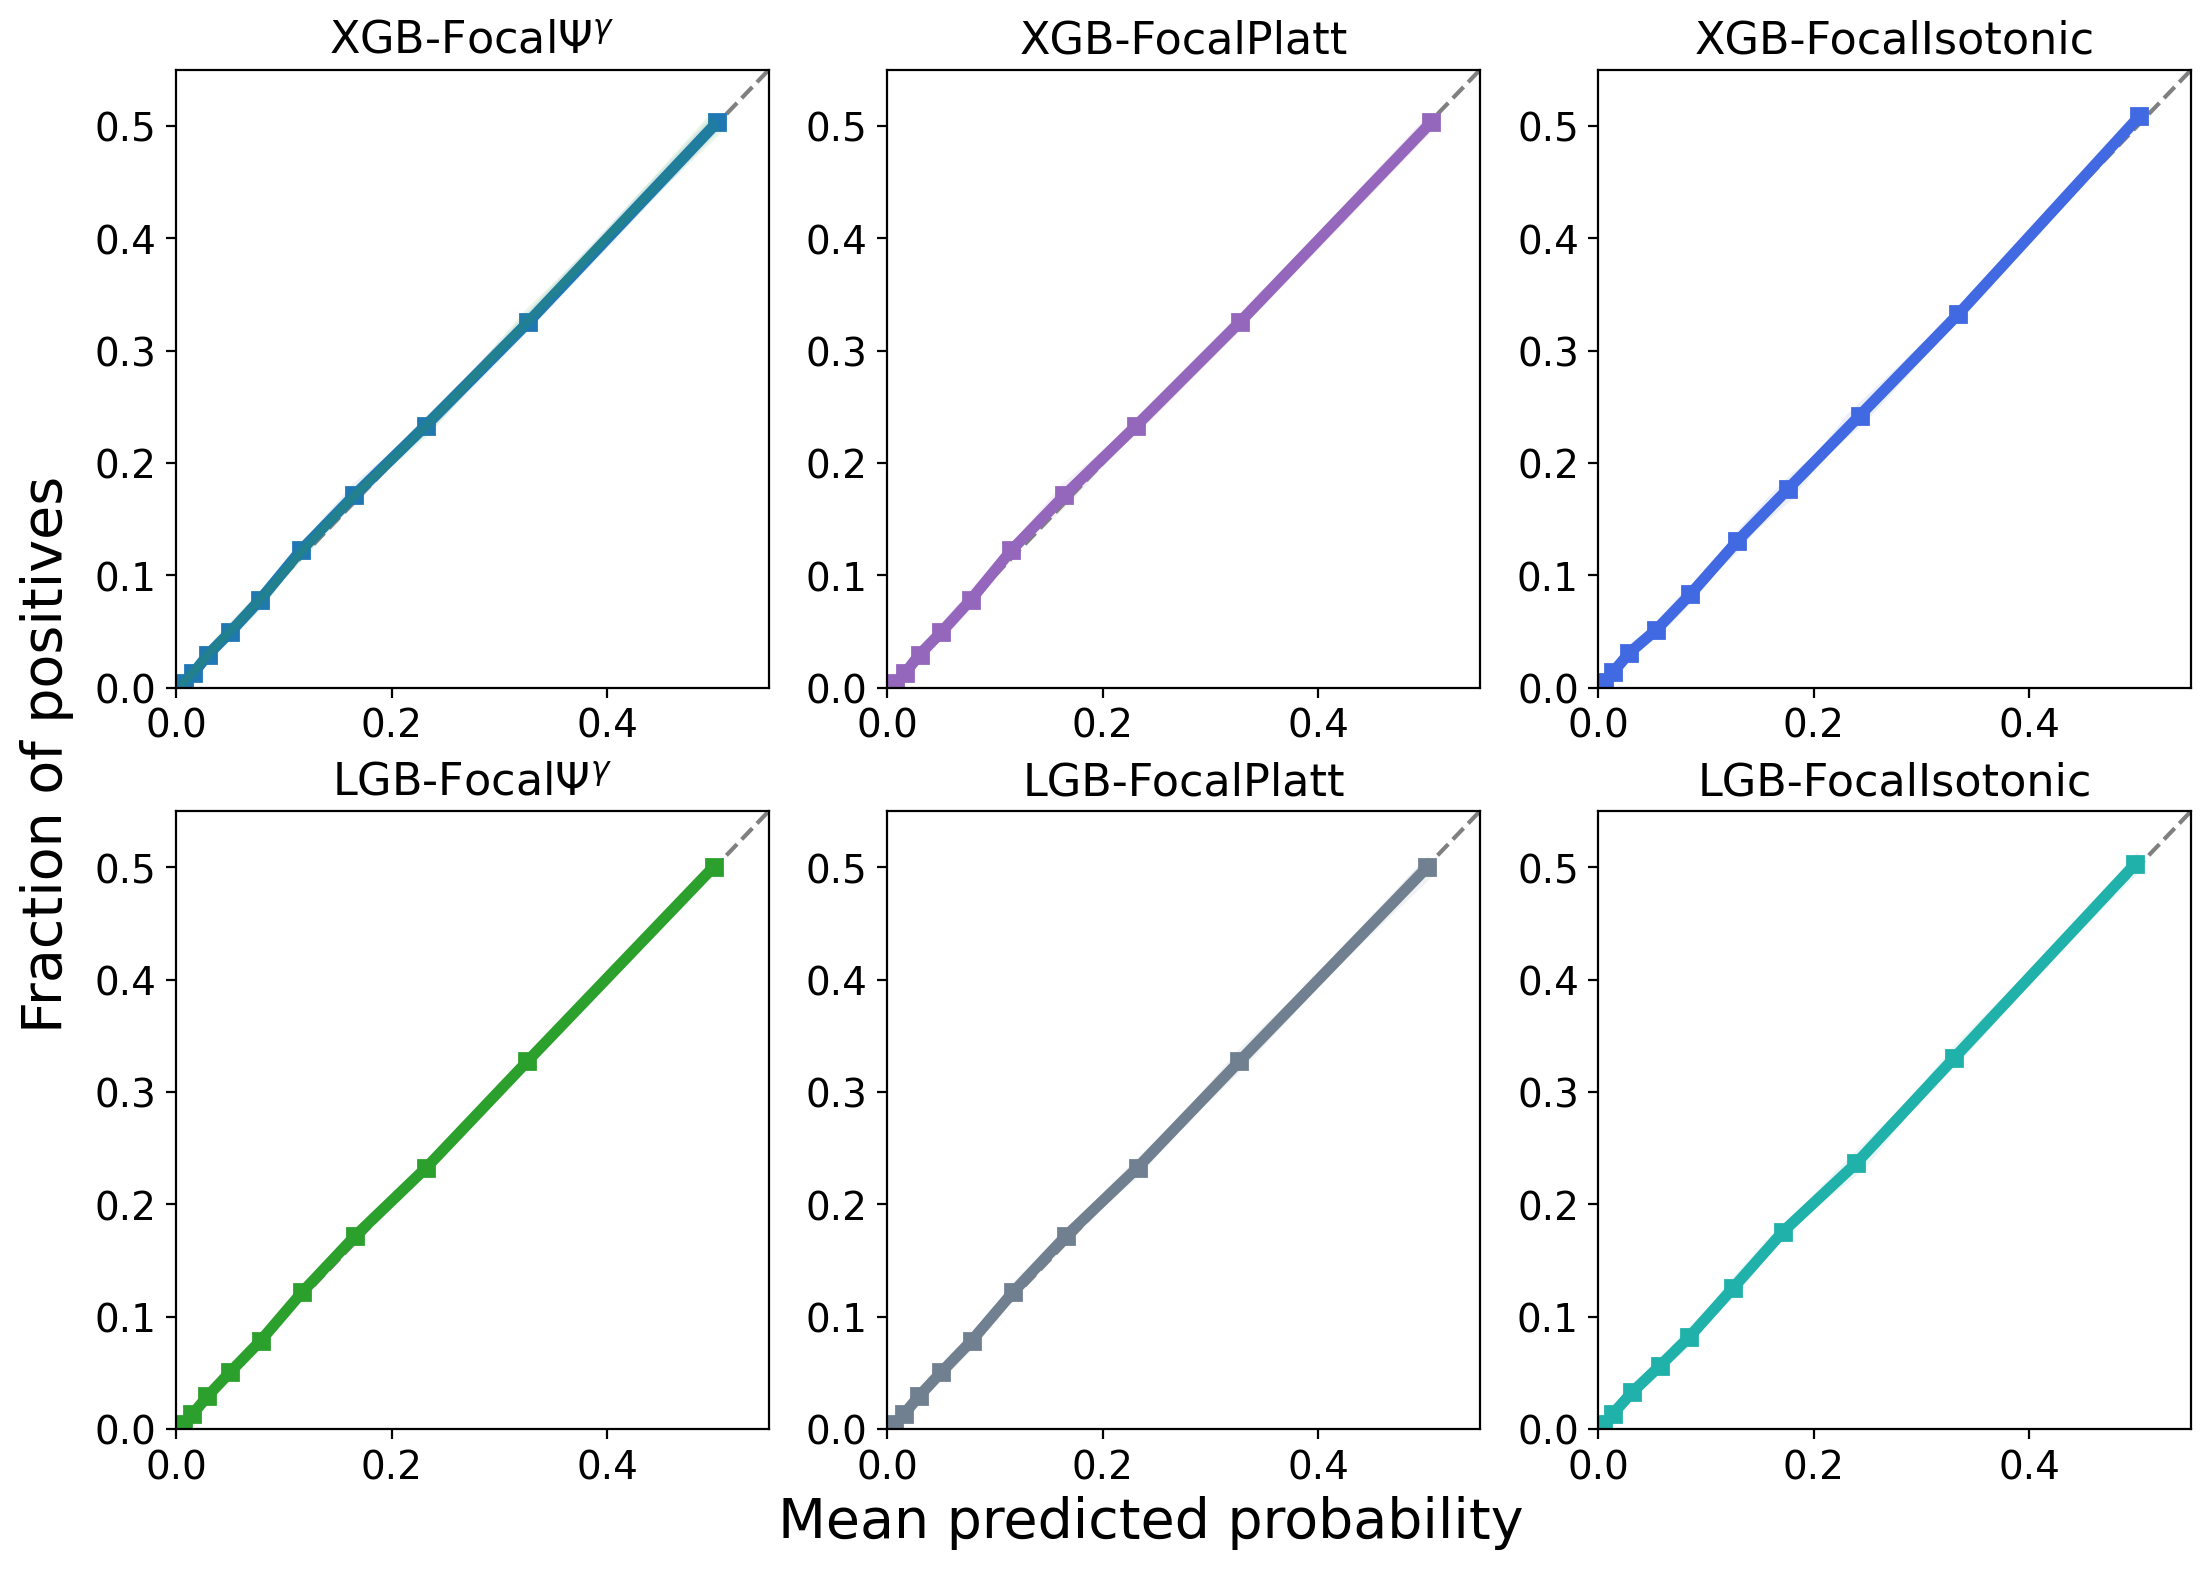

In [26]:
focal_cal_diabetes = plattisocal_results_test_diabetes.copy()
gamma_diabetes = plattiso_results_test_diabetes[['Iteration','Model','Gamma']]
fig, axs = plt.subplots(2, 3, figsize=(13,9),dpi=200)
tot_it = focal_cal_diabetes['Iteration'].value_counts().index.tolist()

for i in tot_it:
    fraction_of_positives, mean_predicted_value = focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_TRUE_XGBFOCALΨ$^γ$'], focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_PRED_XGBFOCALΨ$^γ$']
    axs[0,0].plot(mean_predicted_value, fraction_of_positives, '-',linewidth=3,color='tab:blue',alpha=.1)
axs[0,0].set_xlim([0, 0.55])
axs[0,0].set_ylim([0, 0.55])
axs[0,0].plot([0, 1], [0, 1], '--', color='gray')
axs[0,0].tick_params(axis='both', which='major', labelsize=14)
axs[0,0].tick_params(axis='both', which='minor', labelsize=14)
axs[0,0].set_title('XGB-FocalΨ$^γ$',fontsize=16)
fraction_of_positives, mean_predicted_value = focal_cal_diabetes.groupby('Bin').mean()['Y_TRUE_XGBFOCALΨ$^γ$'], focal_cal_diabetes.groupby('Bin').mean()['Y_PRED_XGBFOCALΨ$^γ$']
axs[0,0].plot(mean_predicted_value, fraction_of_positives,'s-',linewidth=4,color='tab:blue')#+" (BS="+str(np.round(mean_test_results_diabetes['Brier score']['XGB-Focal'],3))+")")
# axs[0,0].legend(fontsize=12)

for i in tot_it:
    fraction_of_positives, mean_predicted_value = focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_TRUE_XGBFOCALPlatt'], focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_PRED_XGBFOCALPlatt']
    axs[0,1].plot(mean_predicted_value, fraction_of_positives, '-',linewidth=3,color='tab:purple',alpha=.1)
axs[0,1].set_xlim([0, 0.55])
axs[0,1].set_ylim([0, 0.55])
axs[0,1].plot([0, 1], [0, 1], '--', color='gray')
axs[0,1].tick_params(axis='both', which='major', labelsize=14)
axs[0,1].tick_params(axis='both', which='minor', labelsize=14)
axs[0,1].set_title('XGB-FocalPlatt',fontsize=16)
fraction_of_positives, mean_predicted_value = focal_cal_diabetes.groupby('Bin').mean()['Y_TRUE_XGBFOCALPlatt'], focal_cal_diabetes.groupby('Bin').mean()['Y_PRED_XGBFOCALPlatt']
axs[0,1].plot(mean_predicted_value, fraction_of_positives,'s-',linewidth=4,color='tab:purple')#+" (BS="+str(np.round(mean_test_results_diabetes['Brier score']['XGB-FocalPLATT'],3))+")")
# axs[0,1].legend(fontsize=12)

for i in tot_it:
    fraction_of_positives, mean_predicted_value = focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_TRUE_XGBFOCALIso'], focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_PRED_XGBFOCALIso']
    axs[0,2].plot(mean_predicted_value, fraction_of_positives, '-',linewidth=3,color='royalblue',alpha=.1)
axs[0,2].set_xlim([0, 0.55])
axs[0,2].set_ylim([0, 0.55])
axs[0,2].plot([0, 1], [0, 1], '--', color='gray')
axs[0,2].tick_params(axis='both', which='major', labelsize=14)
axs[0,2].tick_params(axis='both', which='minor', labelsize=14)
axs[0,2].set_title('XGB-FocalIsotonic',fontsize=16)
fraction_of_positives, mean_predicted_value = focal_cal_diabetes.groupby('Bin').mean()['Y_TRUE_XGBFOCALIso'], focal_cal_diabetes.groupby('Bin').mean()['Y_PRED_XGBFOCALIso']
axs[0,2].plot(mean_predicted_value, fraction_of_positives,'s-',linewidth=4,color='royalblue')#+" (BS="+str(np.round(mean_test_results_diabetes['Brier score']['XGB-FocalIso'],3))+")")
# axs[0,2].legend(fontsize=12)


for i in tot_it:
    fraction_of_positives, mean_predicted_value = focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_TRUE_LGBFOCALΨ$^γ$'], focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_PRED_LGBFOCALΨ$^γ$']
    axs[0,0].plot(mean_predicted_value, fraction_of_positives, '-',linewidth=3,color='tab:green',alpha=.1)
axs[1,0].set_xlim([0, 0.55])
axs[1,0].set_ylim([0, 0.55])
axs[1,0].plot([0, 1], [0, 1], '--', color='gray')
axs[1,0].tick_params(axis='both', which='major', labelsize=14)
axs[1,0].tick_params(axis='both', which='minor', labelsize=14)
axs[1,0].set_title('LGB-FocalΨ$^γ$',fontsize=16)
fraction_of_positives, mean_predicted_value = focal_cal_diabetes.groupby('Bin').mean()['Y_TRUE_LGBFOCALΨ$^γ$'], focal_cal_diabetes.groupby('Bin').mean()['Y_PRED_LGBFOCALΨ$^γ$']
axs[1,0].plot(mean_predicted_value, fraction_of_positives,'s-',linewidth=4,color='tab:green')#+" (BS="+str(np.round(mean_test_results_diabetes['Brier score']['LGB-Focal'],3))+")")
# axs[1,0].legend(fontsize=12)

for i in tot_it:
    fraction_of_positives, mean_predicted_value = focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_TRUE_LGBFOCALPlatt'], focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_PRED_LGBFOCALPlatt']
    axs[1,1].plot(mean_predicted_value, fraction_of_positives, '-',linewidth=3,color='slategrey',alpha=.1)
axs[1,1].set_xlim([0, 0.55])
axs[1,1].set_ylim([0, 0.55])
axs[1,1].plot([0, 1], [0, 1], '--', color='gray')
axs[1,1].tick_params(axis='both', which='major', labelsize=14)
axs[1,1].tick_params(axis='both', which='minor', labelsize=14)
axs[1,1].set_title('LGB-FocalPlatt',fontsize=16)
fraction_of_positives, mean_predicted_value = focal_cal_diabetes.groupby('Bin').mean()['Y_TRUE_LGBFOCALPlatt'], focal_cal_diabetes.groupby('Bin').mean()['Y_PRED_LGBFOCALPlatt']
axs[1,1].plot(mean_predicted_value, fraction_of_positives,'s-',linewidth=4,color='slategrey')#+" (BS="+str(np.round(mean_test_results_diabetes['Brier score']['LGB-FocalPLATT'],3))+")")
# axs[1,1].legend(fontsize=12)

for i in tot_it:
    fraction_of_positives, mean_predicted_value = focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_TRUE_LGBFOCALIso'], focal_cal_diabetes[focal_cal_diabetes['Iteration']==i]['Y_PRED_LGBFOCALIso']
    axs[1,2].plot(mean_predicted_value, fraction_of_positives, '-',linewidth=3,color='lightseagreen',alpha=.1)
axs[1,2].set_xlim([0, 0.55])
axs[1,2].set_ylim([0, 0.55])
axs[1,2].plot([0, 1], [0, 1], '--', color='gray')
axs[1,2].tick_params(axis='both', which='major', labelsize=14)
axs[1,2].tick_params(axis='both', which='minor', labelsize=14)
axs[1,2].set_title('LGB-FocalIsotonic',fontsize=16)
fraction_of_positives, mean_predicted_value = focal_cal_diabetes.groupby('Bin').mean()['Y_TRUE_LGBFOCALIso'], focal_cal_diabetes.groupby('Bin').mean()['Y_PRED_LGBFOCALIso']
axs[1,2].plot(mean_predicted_value, fraction_of_positives,'s-',linewidth=4,color='lightseagreen')#+" (BS="+str(np.round(mean_test_results_diabetes['Brier score']['LGB-FocalIso'],3))+")")
# axs[1,2].legend(fontsize=12)


# lines_labels = [axs[0,0].get_legend_handles_labels(),axs[0,1].get_legend_handles_labels()]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, fontsize=15, ncols=3,bbox_to_anchor=(0.515,0.92),loc="upper center")
fig.text(0.5, 0.065, 'Mean predicted probability', ha='center', fontsize=20)
fig.text(0.065, 0.5, 'Fraction of positives', va='center', rotation='vertical', fontsize=20)
plt.show()
fig.savefig('Calibration_Curve_Diabetes_XGB_LGB_psi_platt_iso.png', bbox_inches='tight')
fig.savefig('Calibration_Curve_Diabetes_XGB_LGB_psi_platt_iso_TIF.tif', bbox_inches='tight')

In [25]:
metric_cols = ['Gamma','ROC_AUC','H measure','Average Precision','Brier score','Log Loss','Sensitivity','Specificity','Balanced Accuracy']
plattiso_results_test_diabetes.groupby(by=['Model']).mean()[metric_cols].round(3)

,Gamma,ROC_AUC,H measure,Average Precision,Brier score,Log Loss,Sensitivity,Specificity,Balanced Accuracy
Model,,,,,,,,,
LGB-Focal,1.033,0.817,0.303,0.440,0.117,0.383,0.923,0.393,0.658
LGB-FocalIso,1.033,0.817,0.301,0.434,0.105,0.338,0.776,0.702,0.739
LGB-FocalPlatt,1.033,0.817,0.303,0.440,0.105,0.338,0.778,0.701,0.739
LGB-FocalΨ$^γ$,1.033,0.817,0.303,0.440,0.105,0.337,0.778,0.700,0.739
XGB-Focal,1.083,0.818,0.304,0.442,0.117,0.383,0.945,0.375,0.660
XGB-FocalIso,1.083,0.817,0.303,0.435,0.105,0.338,0.784,0.696,0.740
XGB-FocalPlatt,1.083,0.818,0.304,0.442,0.105,0.337,0.776,0.704,0.740
XGB-FocalΨ$^γ$,1.083,0.818,0.304,0.442,0.105,0.337,0.778,0.702,0.740
